<a href="https://colab.research.google.com/github/kntszmlk/02010044_NORAL_BULANIK_SISTEMLER_1/blob/main/fuzzy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Veri Seti Sütunları: Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'b', 'lstat', 'medv'],
      dtype='object')
Veri Seti İlk 5 Satır:
       crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        b  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  
Veri Seti Boyutları: 506 örnek, 13 özellik
Toplam 144 parametre kombinasyonu denenecek.

Kombinasyon 1/144: C=3, epsilon=0.1, lambda_reg=0.5, svr_C=0.1
FCM Ortalama RMSE: 3.81 ± 0.38

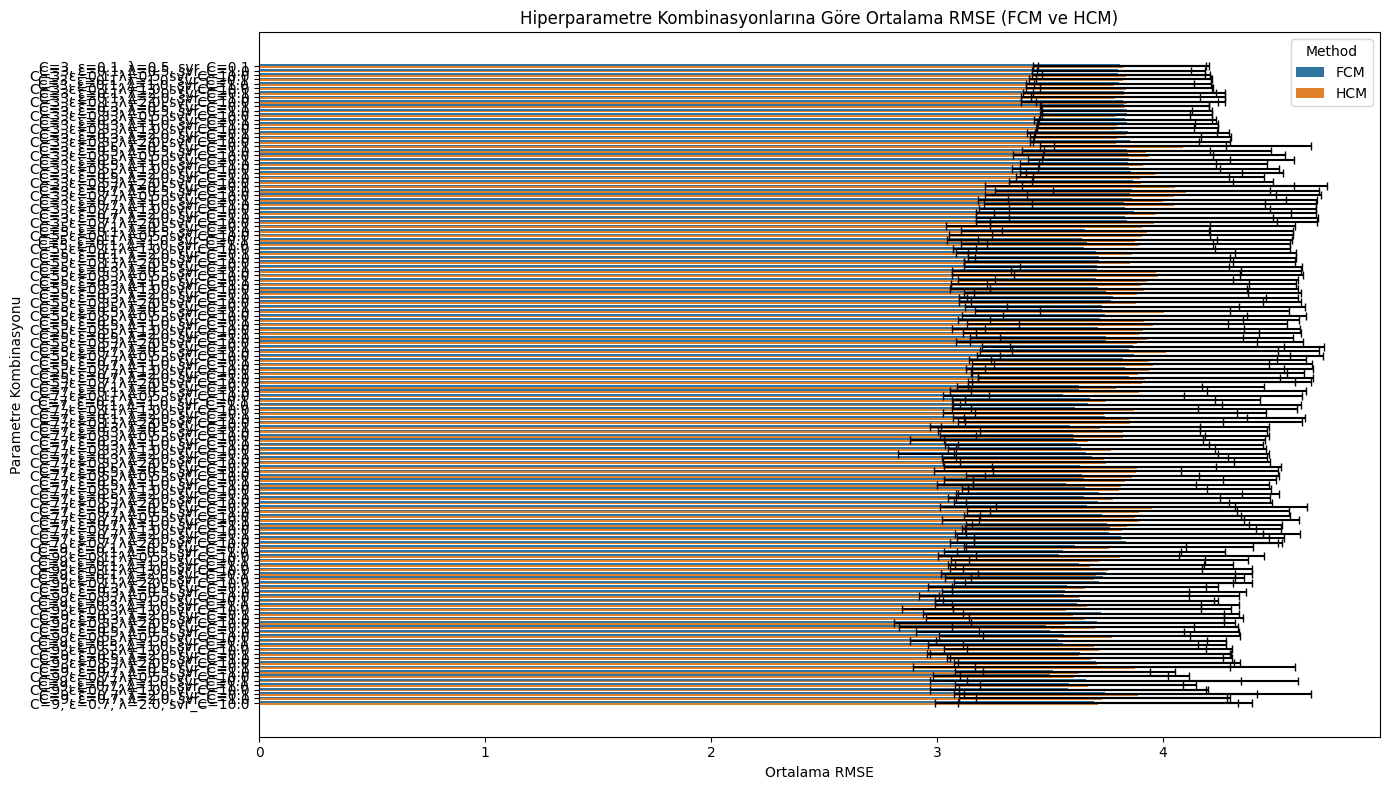

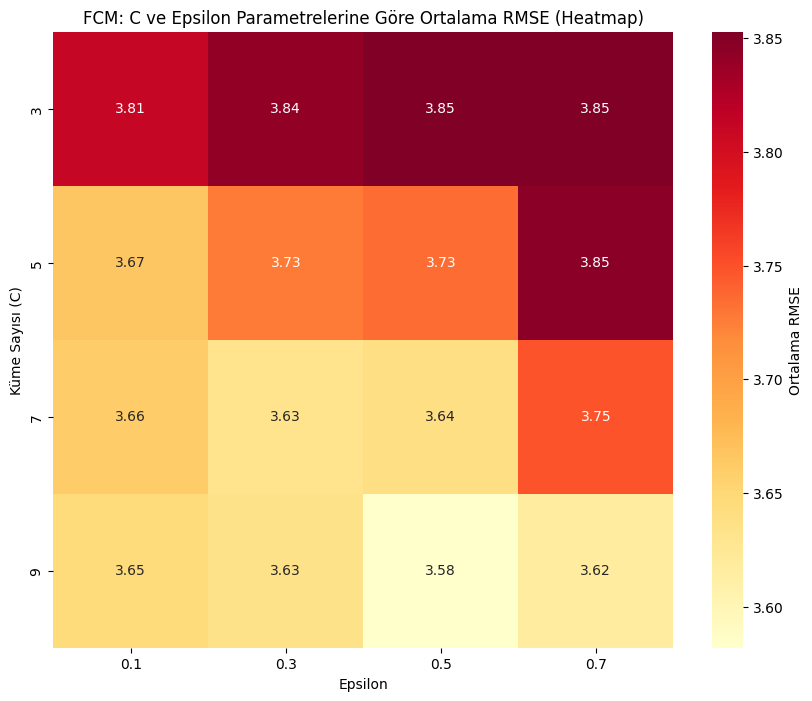

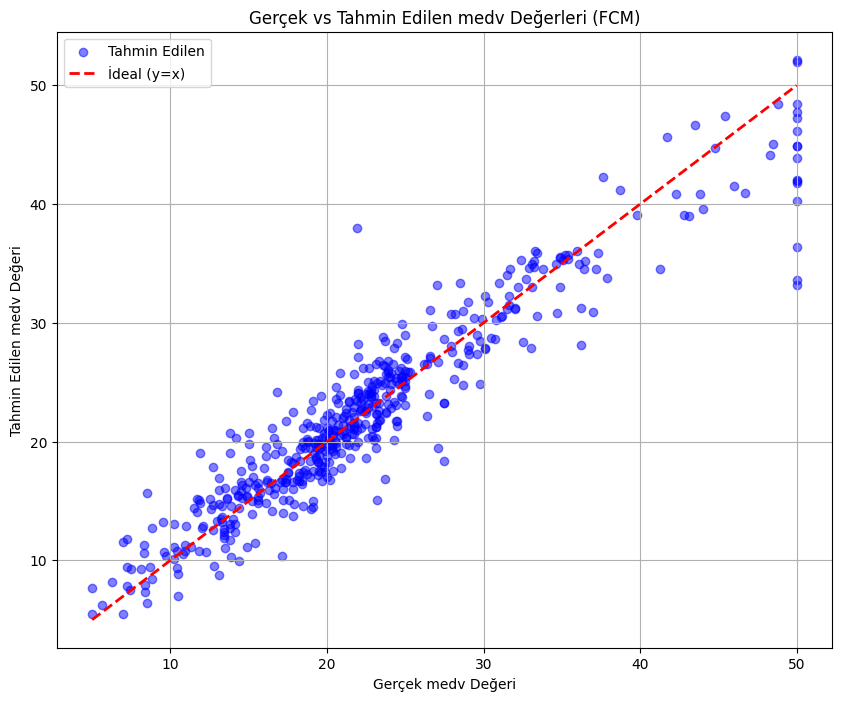

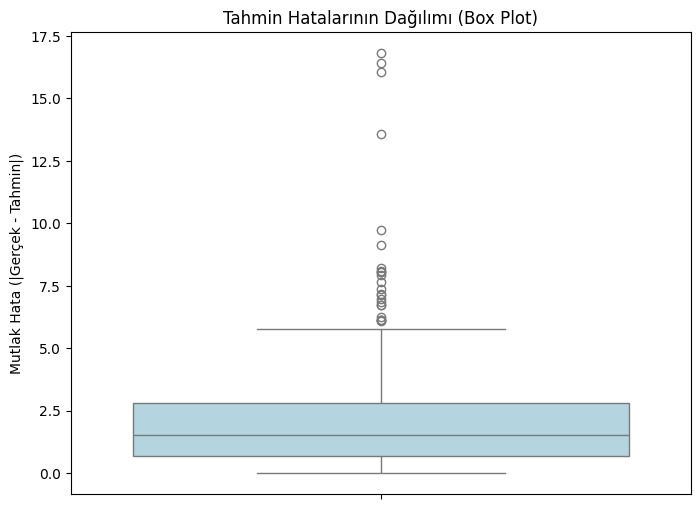

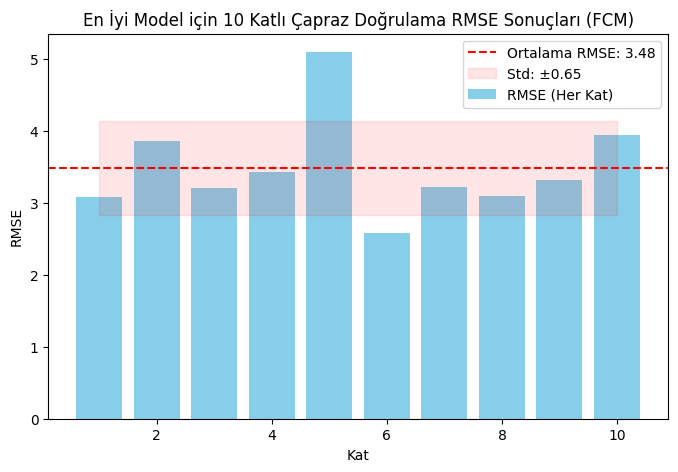

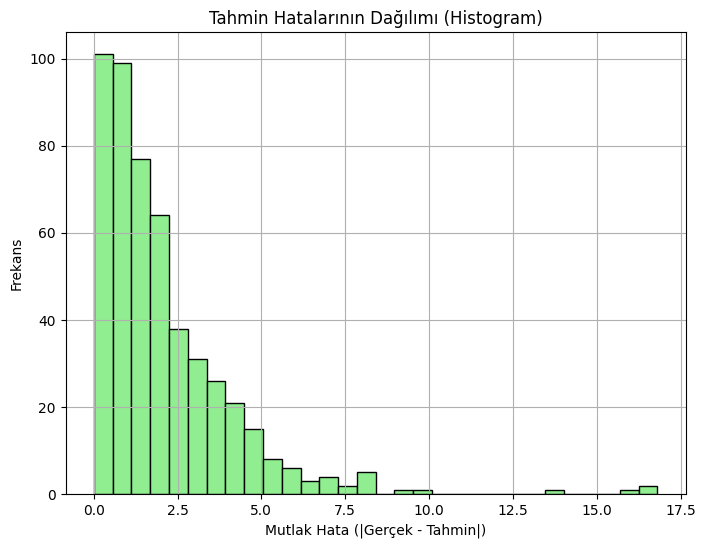

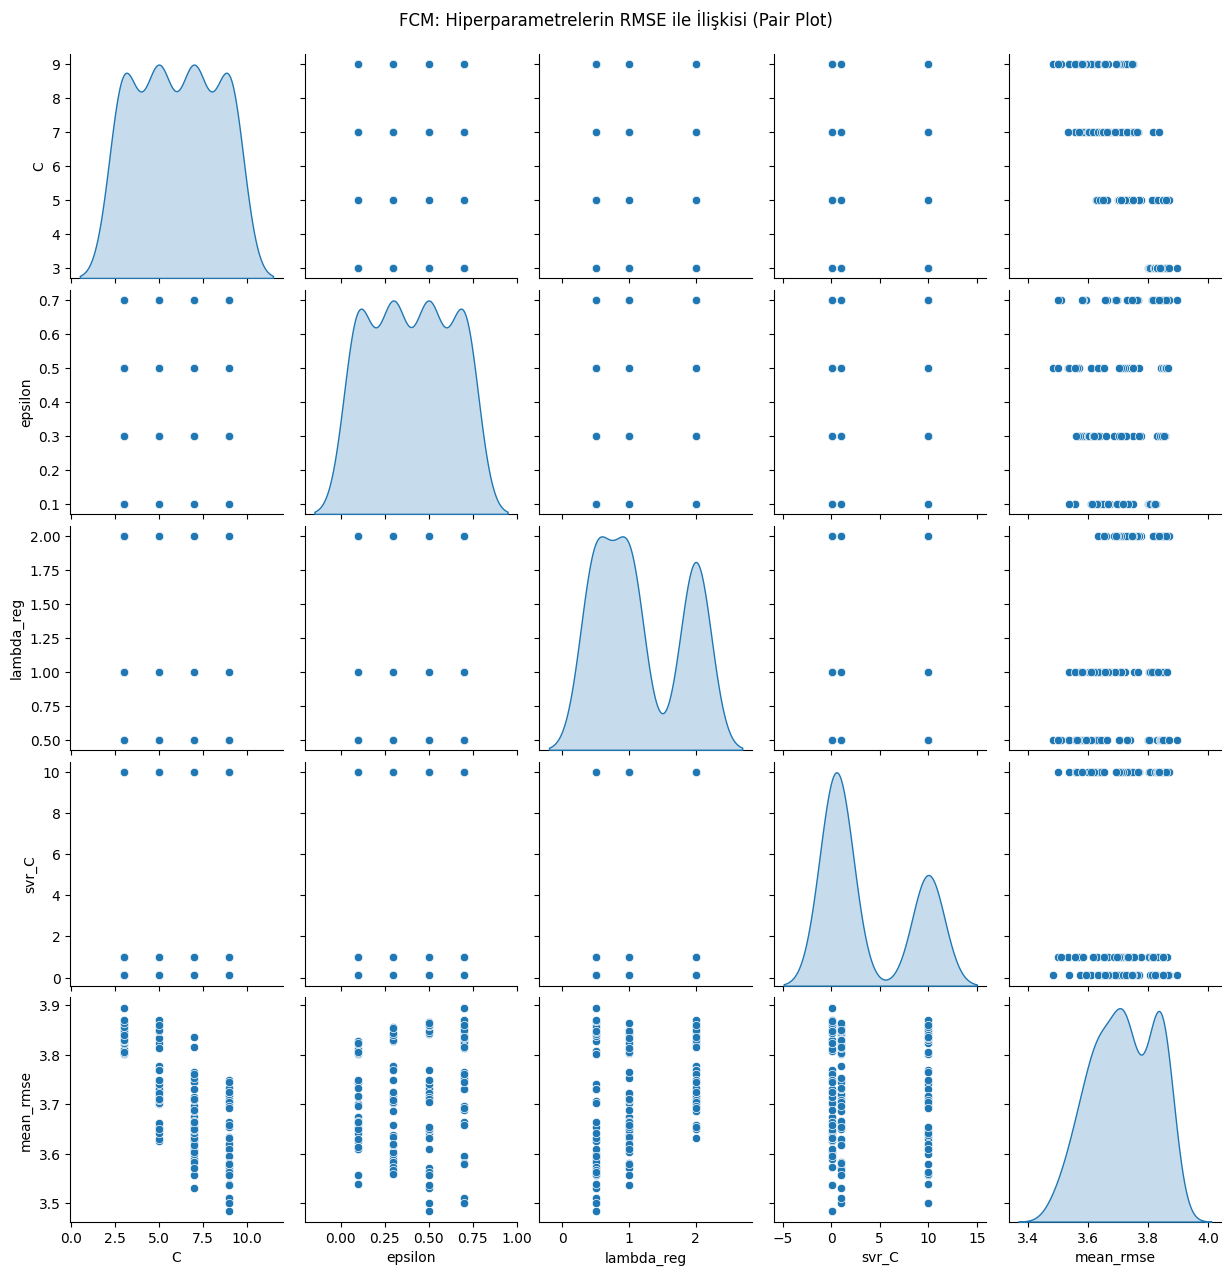


Tablo 5: En İyi 5 FCM Kombinasyonu
 C  epsilon  lambda_reg  svr_C  mean_rmse  std_rmse Method
 9      0.5         0.5    0.1   3.483731  0.652800    FCM
 9      0.5         0.5    1.0   3.500019  0.592589    FCM
 9      0.7         0.5   10.0   3.500409  0.520057    FCM
 9      0.7         0.5    1.0   3.510927  0.432477    FCM
 7      0.5         0.5    1.0   3.531731  0.547023    FCM

Tablo 6: En İyi 5 HCM Kombinasyonu
 C  epsilon  lambda_reg  svr_C  mean_rmse  std_rmse Method
 9      0.3         2.0   10.0   3.564834  0.753732    HCM
 9      0.3         1.0   10.0   3.570923  0.728228    HCM
 9      0.3         2.0    0.1   3.603298  0.664950    HCM
 9      0.3         1.0    0.1   3.606450  0.618006    HCM
 9      0.7         0.5   10.0   3.607488  0.506056    HCM


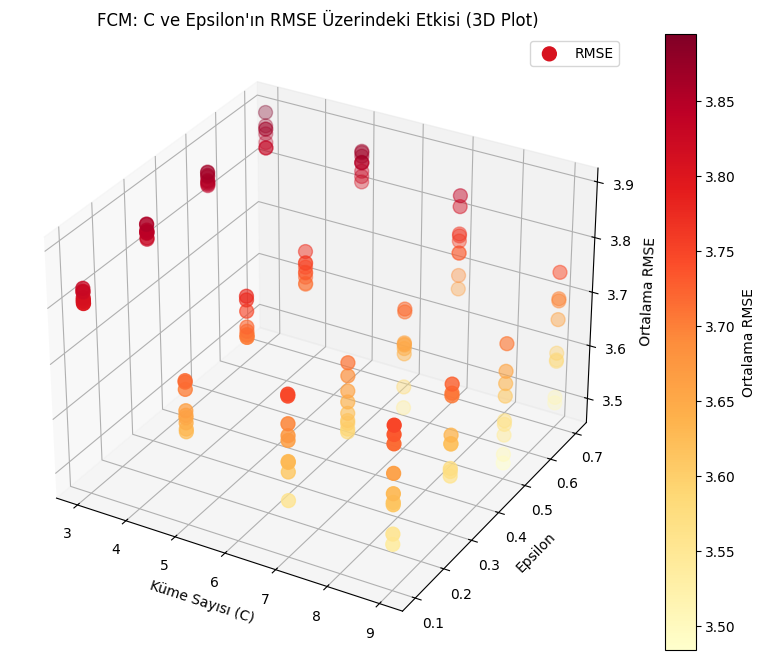

<ipython-input-4-b78059c2a6ae>:462: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Method', y='RMSE', data=rmse_dist_df, palette='Set2')


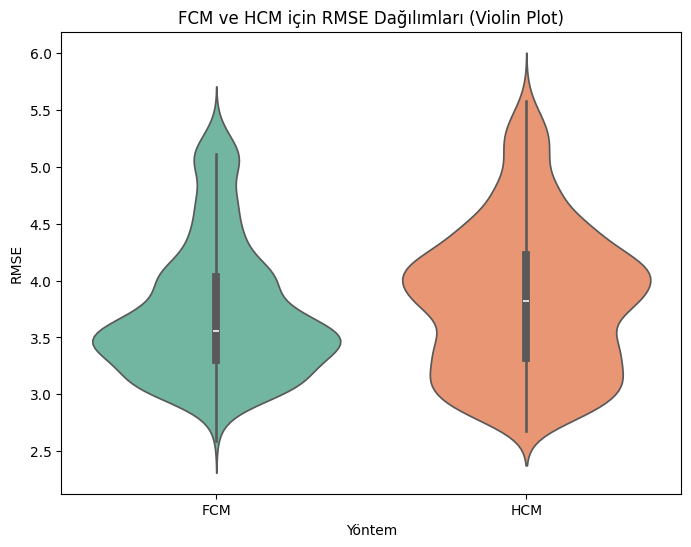

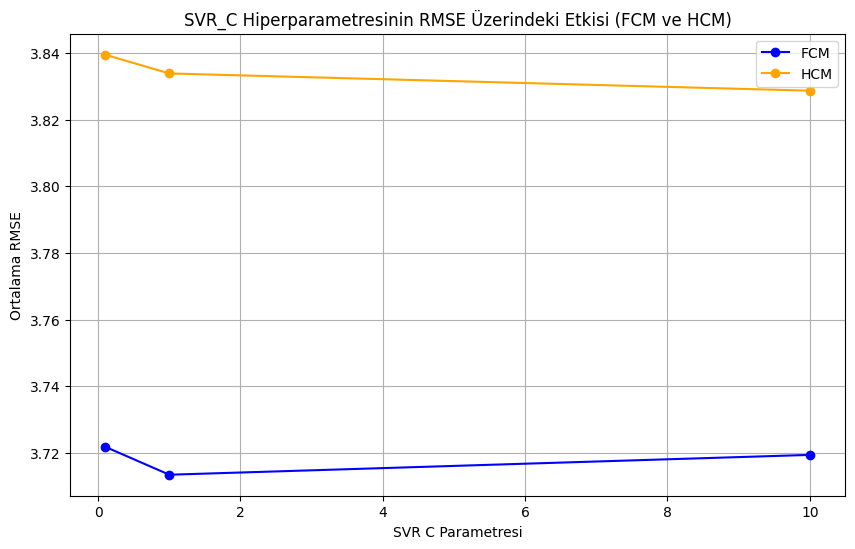

In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

# Veri setini yükleme
data = pd.read_csv("/content/sample_data/BostonHousing.csv")
print("Veri Seti Sütunları:", data.columns)
print("Veri Seti İlk 5 Satır:\n", data.head())

# Tüm özellikleri kullan
X = data[["crim", "zn", "indus", "chas", "nox", "rm", "age", "dis", "rad", "tax", "ptratio", "b", "lstat"]].values
y = data["medv"].values

# Veriyi ölçeklendirme
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Veri seti boyutları
n_samples, n_features = X_scaled.shape
print(f"Veri Seti Boyutları: {n_samples} örnek, {n_features} özellik")

# RFCNN Algoritması için yardımcı fonksiyonlar
def select_support_vectors_svm(X, y, epsilon, C, kernel='linear'):
    svr = SVR(kernel=kernel, epsilon=epsilon, C=C)
    svr.fit(X, y)
    sv_indices = svr.support_
    return sv_indices

def fuzzy_c_means(X, n_clusters, m=2, max_iter=100, tol=1e-4):
    n_samples = X.shape[0]
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X)
    centers = kmeans.cluster_centers_

    for _ in range(max_iter):
        old_centers = centers.copy()
        distances = np.zeros((n_samples, n_clusters))
        for i in range(n_clusters):
            distances[:, i] = np.linalg.norm(X - centers[i], axis=1) + 1e-10
        u = np.zeros((n_samples, n_clusters))
        for i in range(n_clusters):
            for j in range(n_clusters):
                if i == j:
                    continue
                u[:, i] += (distances[:, i] / distances[:, j]) ** (2 / (m - 1))
            u[:, i] = 1 / (u[:, i] + 1e-10)
        for i in range(n_clusters):
            u_m = u[:, i] ** m
            centers[i] = np.sum(u_m[:, np.newaxis] * X, axis=0) / np.sum(u_m)
        if np.linalg.norm(centers - old_centers) < tol:
            break

    u = np.clip(u, 1e-5, 1.0)
    u = u / np.sum(u, axis=1, keepdims=True)
    return centers, u

def hard_c_means(X, n_clusters, max_iter=100, tol=1e-4):
    n_samples = X.shape[0]
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X)
    centers = kmeans.cluster_centers_

    for _ in range(max_iter):
        old_centers = centers.copy()
        distances = np.zeros((n_samples, n_clusters))
        for i in range(n_clusters):
            distances[:, i] = np.linalg.norm(X - centers[i], axis=1)
        labels = np.argmin(distances, axis=1)
        u = np.zeros((n_samples, n_clusters))
        for i in range(n_samples):
            u[i, labels[i]] = 1
        for i in range(n_clusters):
            points_in_cluster = X[u[:, i] == 1]
            if len(points_in_cluster) > 0:
                centers[i] = np.mean(points_in_cluster, axis=0)
        if np.linalg.norm(centers - old_centers) < tol:
            break

    return centers, u

def compute_membership(X, centers, m=2, clustering_type='fcm'):
    n_samples = X.shape[0]
    n_clusters = centers.shape[0]
    distances = np.zeros((n_samples, n_clusters))
    for i in range(n_clusters):
        distances[:, i] = np.linalg.norm(X - centers[i], axis=1) + 1e-10
    u = np.zeros((n_samples, n_clusters))
    if clustering_type == 'fcm':
        for i in range(n_clusters):
            for j in range(n_clusters):
                if i == j:
                    continue
                u[:, i] += (distances[:, i] / distances[:, j]) ** (2 / (m - 1))
            u[:, i] = 1 / (u[:, i] + 1e-10)
        u = np.clip(u, 1e-5, 1.0)
        u = u / np.sum(u, axis=1, keepdims=True)
    else:
        labels = np.argmin(distances, axis=1)
        for i in range(n_samples):
            u[i, labels[i]] = 1
    return u

def train_rfcnn(X, y, centers, membership, lambda_reg):
    n_samples, n_features = X.shape
    n_clusters = centers.shape[0]
    X_design = np.zeros((n_samples, n_clusters * (n_features + 1)))
    for i in range(n_clusters):
        X_design[:, i * (n_features + 1):(i + 1) * (n_features + 1)] = membership[:, i:i+1] * np.hstack([np.ones((n_samples, 1)), X])
    I = np.eye(X_design.shape[1])
    coeffs = np.linalg.inv(X_design.T @ X_design + lambda_reg * I + 1e-6 * np.eye(X_design.shape[1])) @ X_design.T @ y
    return coeffs

def predict_rfcnn(X, centers, coeffs, m=2, clustering_type='fcm'):
    n_samples = X.shape[0]
    n_features = X.shape[1]
    n_clusters = len(centers)
    membership = compute_membership(X, centers, m, clustering_type)
    X_design = np.zeros((n_samples, n_clusters * (n_features + 1)))
    for i in range(n_clusters):
        X_design[:, i * (n_features + 1):(i + 1) * (n_features + 1)] = membership[:, i:i+1] * np.hstack([np.ones((n_samples, 1)), X])
    y_pred = X_design @ coeffs
    return y_pred

# Hiperparametre grid'i tanımlama
param_grid = {
    'C': [3, 5, 7, 9],
    'epsilon': [0.1, 0.3, 0.5, 0.7],
    'lambda_reg': [0.5, 1.0, 2.0],
    'svr_C': [0.1, 1.0, 10.0]
}

param_combinations = list(product(param_grid['C'], param_grid['epsilon'], param_grid['lambda_reg'], param_grid['svr_C']))
print(f"Toplam {len(param_combinations)} parametre kombinasyonu denenecek.")

# FCM ve HCM için sonuçları saklamak
results_fcm = []
results_hcm = []

m = 2
max_iter = 100

for idx, (C, epsilon, lambda_reg, svr_C) in enumerate(param_combinations):
    print(f"\nKombinasyon {idx + 1}/{len(param_combinations)}: C={C}, epsilon={epsilon}, lambda_reg={lambda_reg}, svr_C={svr_C}")

    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    rmse_scores_fcm = []
    rmse_scores_hcm = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

        sv_indices = select_support_vectors_svm(X_train, y_train, epsilon=epsilon, C=svr_C)
        X_sv = X_train[sv_indices]

        centers_fcm, _ = fuzzy_c_means(X_sv, C, m, max_iter)
        membership_train_fcm = compute_membership(X_train, centers_fcm, m, clustering_type='fcm')
        coeffs_fcm = train_rfcnn(X_train, y_train, centers_fcm, membership_train_fcm, lambda_reg)
        y_pred_scaled_fcm = predict_rfcnn(X_test, centers_fcm, coeffs_fcm, m, clustering_type='fcm')
        y_pred_fcm = scaler_y.inverse_transform(y_pred_scaled_fcm.reshape(-1, 1)).flatten()
        y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
        rmse_fcm = np.sqrt(mean_squared_error(y_test_orig, y_pred_fcm))
        rmse_scores_fcm.append(rmse_fcm)

        centers_hcm, _ = hard_c_means(X_sv, C, max_iter)
        membership_train_hcm = compute_membership(X_train, centers_hcm, m, clustering_type='hcm')
        coeffs_hcm = train_rfcnn(X_train, y_train, centers_hcm, membership_train_hcm, lambda_reg)
        y_pred_scaled_hcm = predict_rfcnn(X_test, centers_hcm, coeffs_hcm, m, clustering_type='hcm')
        y_pred_hcm = scaler_y.inverse_transform(y_pred_scaled_hcm.reshape(-1, 1)).flatten()
        rmse_hcm = np.sqrt(mean_squared_error(y_test_orig, y_pred_hcm))
        rmse_scores_hcm.append(rmse_hcm)

    mean_rmse_fcm = np.mean(rmse_scores_fcm)
    std_rmse_fcm = np.std(rmse_scores_fcm)
    mean_rmse_hcm = np.mean(rmse_scores_hcm)
    std_rmse_hcm = np.std(rmse_scores_hcm)

    results_fcm.append({
        'C': C,
        'epsilon': epsilon,
        'lambda_reg': lambda_reg,
        'svr_C': svr_C,
        'mean_rmse': mean_rmse_fcm,
        'std_rmse': std_rmse_fcm
    })
    results_hcm.append({
        'C': C,
        'epsilon': epsilon,
        'lambda_reg': lambda_reg,
        'svr_C': svr_C,
        'mean_rmse': mean_rmse_hcm,
        'std_rmse': std_rmse_hcm
    })

    print(f"FCM Ortalama RMSE: {mean_rmse_fcm:.2f} ± {std_rmse_fcm:.2f}")
    print(f"HCM Ortalama RMSE: {mean_rmse_hcm:.2f} ± {std_rmse_hcm:.2f}")

results_fcm_df = pd.DataFrame(results_fcm)
results_hcm_df = pd.DataFrame(results_hcm)

# Tablo 1: FCM ve HCM Sonuçlarının Detaylı Tablosu
# Açıklama: FCM ve HCM için tüm parametre kombinasyonlarının ortalama RMSE ve standart sapma değerlerini içeren bir tablo.
print("\nTablo 1: FCM Sonuçları")
print(results_fcm_df.to_string(index=False))
print("\nTablo 2: HCM Sonuçları")
print(results_hcm_df.to_string(index=False))

# En iyi sonuçları bul
best_fcm = results_fcm_df.loc[results_fcm_df['mean_rmse'].idxmin()]
best_hcm = results_hcm_df.loc[results_hcm_df['mean_rmse'].idxmin()]

# Tablo 3: En İyi FCM ve HCM Sonuçlarının Karşılaştırması
# Açıklama: En iyi FCM ve HCM sonuçlarını yan yana gösteren bir tablo.
best_comparison = pd.DataFrame({
    'Method': ['FCM', 'HCM'],
    'C': [best_fcm['C'], best_hcm['C']],
    'epsilon': [best_fcm['epsilon'], best_hcm['epsilon']],
    'lambda_reg': [best_fcm['lambda_reg'], best_hcm['lambda_reg']],
    'svr_C': [best_fcm['svr_C'], best_hcm['svr_C']],
    'Mean RMSE': [best_fcm['mean_rmse'], best_hcm['mean_rmse']],
    'Std RMSE': [best_fcm['std_rmse'], best_hcm['std_rmse']]
})
print("\nTablo 3: En İyi FCM ve HCM Karşılaştırması")
print(best_comparison.to_string(index=False))

print("\nFCM ve HCM Karşılaştırma Sonuçları:")
print(f"En İyi FCM: C={best_fcm['C']}, epsilon={best_fcm['epsilon']}, lambda_reg={best_fcm['lambda_reg']}, svr_C={best_fcm['svr_C']}, "
      f"Ortalama RMSE: {best_fcm['mean_rmse']:.2f} ± {best_fcm['std_rmse']:.2f}")
print(f"En İyi HCM: C={best_hcm['C']}, epsilon={best_hcm['epsilon']}, lambda_reg={best_hcm['lambda_reg']}, svr_C={best_hcm['svr_C']}, "
      f"Ortalama RMSE: {best_hcm['mean_rmse']:.2f} ± {best_hcm['std_rmse']:.2f}")

if best_fcm['mean_rmse'] < best_hcm['mean_rmse']:
    best_method = 'fcm'
    best_result = best_fcm
    print("\nSeçilen Yöntem: FCM")
else:
    best_method = 'hcm'
    best_result = best_hcm
    print("\nSeçilen Yöntem: HCM")

C_best = int(best_result['C'])
epsilon_best = best_result['epsilon']
lambda_reg_best = best_result['lambda_reg']
svr_C_best = best_result['svr_C']

sv_indices = select_support_vectors_svm(X_scaled, y_scaled, epsilon=epsilon_best, C=svr_C_best)
X_sv = X_scaled[sv_indices]

if best_method == 'fcm':
    centers, _ = fuzzy_c_means(X_sv, C_best, m, max_iter)
else:
    centers, _ = hard_c_means(X_sv, C_best, max_iter)

membership = compute_membership(X_scaled, centers, m, clustering_type=best_method)
coeffs = train_rfcnn(X_scaled, y_scaled, centers, membership, lambda_reg_best)

y_pred_scaled = predict_rfcnn(X_scaled, centers, coeffs, m, clustering_type=best_method)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

final_rmse = np.sqrt(mean_squared_error(y, y_pred))
print(f"\nTüm Veri Seti RMSE (En İyi Model, {best_method.upper()}): {final_rmse:.2f}")

# Tahmin ve Gerçek Değerleri Karşılaştırma Tablosu
# Açıklama: İlk 10 veri noktası için gerçek ve tahmin edilen medv değerlerini gösteren bir tablo.
example_data = X[:10]
example_true = y[:10]
example_data_scaled = scaler_X.transform(example_data)
example_pred_scaled = predict_rfcnn(example_data_scaled, centers, coeffs, m, clustering_type=best_method)
example_pred = scaler_y.inverse_transform(example_pred_scaled.reshape(-1, 1)).flatten()
comparison_df = pd.DataFrame({
    'Index': range(10),
    'Gerçek medv': example_true,
    'Tahmin Edilen medv': example_pred,
    'Hata': np.abs(example_true - example_pred)
})
print("\nTablo 4: İlk 10 Veri Noktası için Gerçek ve Tahmin Edilen Değerler")
print(comparison_df.to_string(index=False))

# Görselleştirme 1: FCM ve HCM için Ortalama RMSE Karşılaştırması (Bar Plot)
# Açıklama: Tüm parametre kombinasyonları için FCM ve HCM'nin ortalama RMSE değerlerini karşılaştıran bir bar plot.
results_fcm_df['Method'] = 'FCM'
results_hcm_df['Method'] = 'HCM'
results_combined = pd.concat([results_fcm_df, results_hcm_df])
results_combined['Combination'] = results_combined.apply(
    lambda row: f"C={row['C']}, ε={row['epsilon']}, λ={row['lambda_reg']}, svr_C={row['svr_C']}", axis=1)

plt.figure(figsize=(14, 8))
sns.barplot(data=results_combined, x='mean_rmse', y='Combination', hue='Method')
plt.errorbar(x=results_combined['mean_rmse'], y=results_combined['Combination'], xerr=results_combined['std_rmse'], fmt='none', c='black', capsize=3)
plt.xlabel('Ortalama RMSE')
plt.ylabel('Parametre Kombinasyonu')
plt.title('Hiperparametre Kombinasyonlarına Göre Ortalama RMSE (FCM ve HCM)')
plt.tight_layout()
plt.show()

# Görselleştirme 2: Heatmap ile Hiperparametrelerin RMSE Üzerindeki Etkisi
# Açıklama: FCM için hiperparametrelerin (C, epsilon, lambda_reg, svr_C) RMSE üzerindeki etkisini gösteren bir heatmap.
pivot_fcm = results_fcm_df.pivot_table(index='C', columns='epsilon', values='mean_rmse')
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_fcm, annot=True, fmt=".2f", cmap='YlOrRd', cbar_kws={'label': 'Ortalama RMSE'})
plt.title('FCM: C ve Epsilon Parametrelerine Göre Ortalama RMSE (Heatmap)')
plt.xlabel('Epsilon')
plt.ylabel('Küme Sayısı (C)')
plt.show()

# Görselleştirme 3: Gerçek vs Tahmin Edilen Değerler (Scatter Plot)
# Açıklama: Tüm veri seti için gerçek ve tahmin edilen medv değerlerini karşılaştıran bir scatter plot.
plt.figure(figsize=(10, 8))
plt.scatter(y, y_pred, alpha=0.5, color='blue', label='Tahmin Edilen')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='İdeal (y=x)')
plt.xlabel('Gerçek medv Değeri')
plt.ylabel('Tahmin Edilen medv Değeri')
plt.title(f'Gerçek vs Tahmin Edilen medv Değerleri ({best_method.upper()})')
plt.legend()
plt.grid(True)
plt.show()

# Görselleştirme 4: Hata Dağılımı (Box Plot)
# Açıklama: Tahmin hatalarının dağılımını gösteren bir box plot.
errors = np.abs(y - y_pred)
plt.figure(figsize=(8, 6))
sns.boxplot(y=errors, color='lightblue')
plt.ylabel('Mutlak Hata (|Gerçek - Tahmin|)')
plt.title('Tahmin Hatalarının Dağılımı (Box Plot)')
plt.show()

# Görselleştirme 5: En İyi Modelin Çapraz Doğrulama RMSE Grafiği
# Açıklama: En iyi model için 10 katlı çapraz doğrulama RMSE değerlerini gösteren bir bar plot.
kf = KFold(n_splits=10, shuffle=True, random_state=42)
rmse_scores_best = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

    sv_indices = select_support_vectors_svm(X_train, y_train, epsilon=epsilon_best, C=svr_C_best)
    X_sv = X_train[sv_indices]

    if best_method == 'fcm':
        centers, _ = fuzzy_c_means(X_sv, C_best, m, max_iter)
    else:
        centers, _ = hard_c_means(X_sv, C_best, max_iter)

    membership_train = compute_membership(X_train, centers, m, clustering_type=best_method)
    coeffs = train_rfcnn(X_train, y_train, centers, membership_train, lambda_reg_best)

    y_pred_scaled = predict_rfcnn(X_test, centers, coeffs, m, clustering_type=best_method)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
    rmse_scores_best.append(rmse)

plt.figure(figsize=(8, 5))
plt.bar(range(1, 11), rmse_scores_best, color='skyblue', label='RMSE (Her Kat)')
plt.axhline(best_result['mean_rmse'], color='red', linestyle='--', label=f'Ortalama RMSE: {best_result["mean_rmse"]:.2f}')
plt.fill_between(range(1, 11), best_result['mean_rmse'] - best_result['std_rmse'],
                 best_result['mean_rmse'] + best_result['std_rmse'], color='red', alpha=0.1,
                 label=f'Std: ±{best_result["std_rmse"]:.2f}')
plt.xlabel('Kat')
plt.ylabel('RMSE')
plt.title(f'En İyi Model için 10 Katlı Çapraz Doğrulama RMSE Sonuçları ({best_method.upper()})')
plt.legend()
plt.show()

# Görselleştirme 6: Hata Dağılımı (Histogram)
# Açıklama: Tahmin hatalarının dağılımını gösteren bir histogram.
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, color='lightgreen', edgecolor='black')
plt.xlabel('Mutlak Hata (|Gerçek - Tahmin|)')
plt.ylabel('Frekans')
plt.title('Tahmin Hatalarının Dağılımı (Histogram)')
plt.grid(True)
plt.show()

# Görselleştirme 7: Hiperparametrelerin RMSE Üzerindeki Etkisi (Pair Plot)
# Açıklama: FCM için hiperparametrelerin (C, epsilon, lambda_reg, svr_C) RMSE ile ilişkisini gösteren bir pair plot.
sns.pairplot(results_fcm_df[['C', 'epsilon', 'lambda_reg', 'svr_C', 'mean_rmse']], diag_kind='kde')
plt.suptitle('FCM: Hiperparametrelerin RMSE ile İlişkisi (Pair Plot)', y=1.02)
plt.show()
# Ek Tablo 5: En İyi 5 FCM ve HCM Kombinasyonu
# Açıklama: FCM ve HCM için en düşük RMSE'ye sahip 5 parametre kombinasyonunu sıralı olarak gösterir.
top5_fcm = results_fcm_df.sort_values(by='mean_rmse').head(5)
top5_hcm = results_hcm_df.sort_values(by='mean_rmse').head(5)

print("\nTablo 5: En İyi 5 FCM Kombinasyonu")
print(top5_fcm.to_string(index=False))
print("\nTablo 6: En İyi 5 HCM Kombinasyonu")
print(top5_hcm.to_string(index=False))

# Görselleştirme 8: 3D Plot ile Hiperparametrelerin RMSE Üzerindeki Etkisi
# Açıklama: FCM için C ve epsilon hiperparametrelerinin RMSE üzerindeki etkisini 3D bir grafikle gösterir.
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# FCM için C, epsilon ve mean_rmse değerlerini al
x = results_fcm_df['C']
y = results_fcm_df['epsilon']
z = results_fcm_df['mean_rmse']

# 3D scatter plot
scatter = ax.scatter(x, y, z, c=z, cmap='YlOrRd', s=100, label='RMSE')
fig.colorbar(scatter, ax=ax, label='Ortalama RMSE')

ax.set_xlabel('Küme Sayısı (C)')
ax.set_ylabel('Epsilon')
ax.set_zlabel('Ortalama RMSE')
ax.set_title('FCM: C ve Epsilon\'ın RMSE Üzerindeki Etkisi (3D Plot)')
plt.legend()
plt.show()

# Görselleştirme 9: Violin Plot ile FCM ve HCM RMSE Dağılımlarının Karşılaştırması
# Açıklama: FCM ve HCM için çapraz doğrulama RMSE değerlerinin dağılımını violin plot ile karşılaştırır.
# Her parametre kombinasyonu için tüm katların RMSE değerlerini saklamak için listeler
all_rmse_fcm = []
all_rmse_hcm = []

for idx, (C, epsilon, lambda_reg, svr_C) in enumerate(param_combinations):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_scaled)):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y_scaled[train_idx], y_scaled[test_idx]

        sv_indices = select_support_vectors_svm(X_train, y_train, epsilon=epsilon, C=svr_C)
        X_sv = X_train[sv_indices]

        centers_fcm, _ = fuzzy_c_means(X_sv, C, m, max_iter)
        membership_train_fcm = compute_membership(X_train, centers_fcm, m, clustering_type='fcm')
        coeffs_fcm = train_rfcnn(X_train, y_train, centers_fcm, membership_train_fcm, lambda_reg)
        y_pred_scaled_fcm = predict_rfcnn(X_test, centers_fcm, coeffs_fcm, m, clustering_type='fcm')
        y_pred_fcm = scaler_y.inverse_transform(y_pred_scaled_fcm.reshape(-1, 1)).flatten()
        y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
        rmse_fcm = np.sqrt(mean_squared_error(y_test_orig, y_pred_fcm))
        all_rmse_fcm.append(rmse_fcm)

        centers_hcm, _ = hard_c_means(X_sv, C, max_iter)
        membership_train_hcm = compute_membership(X_train, centers_hcm, m, clustering_type='hcm')
        coeffs_hcm = train_rfcnn(X_train, y_train, centers_hcm, membership_train_hcm, lambda_reg)
        y_pred_scaled_hcm = predict_rfcnn(X_test, centers_hcm, coeffs_hcm, m, clustering_type='hcm')
        y_pred_hcm = scaler_y.inverse_transform(y_pred_scaled_hcm.reshape(-1, 1)).flatten()
        rmse_hcm = np.sqrt(mean_squared_error(y_test_orig, y_pred_hcm))
        all_rmse_hcm.append(rmse_hcm)

# Violin plot için veri çerçevesi oluştur
rmse_dist_df = pd.DataFrame({
    'RMSE': all_rmse_fcm + all_rmse_hcm,
    'Method': ['FCM'] * len(all_rmse_fcm) + ['HCM'] * len(all_rmse_hcm)
})

plt.figure(figsize=(8, 6))
sns.violinplot(x='Method', y='RMSE', data=rmse_dist_df, palette='Set2')
plt.xlabel('Yöntem')
plt.ylabel('RMSE')
plt.title('FCM ve HCM için RMSE Dağılımları (Violin Plot)')
plt.show()

# Görselleştirme 10: SVR_C Hiperparametresinin RMSE Üzerindeki Etkisi (Line Plot)
# Açıklama: svr_C hiperparametresinin FCM ve HCM için ortalama RMSE üzerindeki etkisini bir çizgi grafiği ile gösterir.
svr_c_analysis_fcm = results_fcm_df.groupby('svr_C')['mean_rmse'].mean().reset_index()
svr_c_analysis_hcm = results_hcm_df.groupby('svr_C')['mean_rmse'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(svr_c_analysis_fcm['svr_C'], svr_c_analysis_fcm['mean_rmse'], marker='o', label='FCM', color='blue')
plt.plot(svr_c_analysis_hcm['svr_C'], svr_c_analysis_hcm['mean_rmse'], marker='o', label='HCM', color='orange')
plt.xlabel('SVR C Parametresi')
plt.ylabel('Ortalama RMSE')
plt.title('SVR_C Hiperparametresinin RMSE Üzerindeki Etkisi (FCM ve HCM)')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
from graphviz import Digraph

# Akış diyagramını oluştur
dot = Digraph(comment='RFCNN Algoritması Akış Diyagramı', format='png')
dot.attr(rankdir='TB', size='4,6')  # Genişlik: ~4 inç, Yükseklik: ~6 inç (A4 için uygun)
dot.attr('graph', dpi='300', margin='0.1')  # Yüksek çözünürlük ve kenar boşluğu
dot.attr('node', shape='box', style='filled', fillcolor='white', fontname='Helvetica', fontsize='8', margin='0.05')
dot.attr('edge', fontname='Helvetica', fontsize='7', arrowsize='0.8')

# Başlangıç
dot.node('A', 'Başlangıç', fillcolor='lightgray', shape='oval')

# Veri Yükleme ve Ön İşleme
dot.node('B', 'Veri Setini Yükle\n(BostonHousing.csv)')
dot.node('C', 'Özellik ve Hedefi Ayır')
dot.node('D', 'Veriyi Ölçeklendir\n(StandardScaler)')

# Hiperparametre Grid'i
dot.node('E', 'Hiperparametre Grid\'i\nTanımla')

# Çapraz Doğrulama
dot.node('F', '10 Katlı Çapraz\nDoğrulama Başlat')
dot.node('G', 'Eğitim ve Test\nVerilerini Böl')

# SVM Destek Vektör Seçimi
dot.node('H', 'SVM ile Destek\nVektörlerini Seç')

# Kümeleme (FCM ve HCM paralel akış)
with dot.subgraph(name='cluster_1') as c:
    c.attr(label='Kümeleme', style='filled', fillcolor='lightgrey', fontsize='8')
    c.node('I', 'FCM Kümeleme')
    c.node('J', 'HCM Kümeleme')
    c.node('K', 'Üyelik Matrisini\nHesapla')

# RFCNN Model Eğitimi ve Tahmin
dot.node('L', 'RFCNN Modelini\nEğit')
dot.node('M', 'Test Verisinde\nTahmin Yap')
dot.node('N', 'RMSE Hesapla')

# Sonuçlar ve Döngü Kontrolü
dot.node('O', 'RMSE Sonuçlarını\nSakla')
dot.node('P', 'Tüm Parametreler\nBitti mi?', shape='diamond')
dot.node('Q', 'En İyi Modeli\nSeç')

# Tüm Veride Tahmin
dot.node('R', 'En İyi Model ile\nTüm Veride Tahmin')

# Bitiş
dot.node('S', 'Bitiş', fillcolor='lightgray', shape='oval')

# Kenarları (Edges) Ekle
dot.edge('A', 'B', label='')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('D', 'E')
dot.edge('E', 'F')
dot.edge('F', 'G')
dot.edge('G', 'H')
dot.edge('H', 'I', label='FCM')
dot.edge('H', 'J', label='HCM')
dot.edge('I', 'K')
dot.edge('J', 'K')
dot.edge('K', 'L')
dot.edge('L', 'M')
dot.edge('M', 'N')
dot.edge('N', 'O')
dot.edge('O', 'P')
dot.edge('P', 'G', label='Hayır')
dot.edge('P', 'Q', label='Evet')
dot.edge('Q', 'R')
dot.edge('R', 'S')

# Akış diyagramını kaydet
dot.render('RFCNN_Akis_Diyagrami', view=False)
print("Akış diyagramı 'RFCNN_Akis_Diyagrami.png' olarak kaydedildi.")

Akış diyagramı 'RFCNN_Akis_Diyagrami.png' olarak kaydedildi.
